In [26]:
using DataFrames
using Gadfly
set_default_plot_size(30cm, 12cm)
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [27]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        if i == 1
            # Include those that fall before the beggining of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
            out_counts[i] = sum(in_weight[temp_bool])
        elseif i == length(in_bins)-1
            # Include those that fall after the end of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
            out_counts[i] = sum(in_weight[temp_bool])
        else
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

read_ptraj_modes (generic function with 3 methods)

In [28]:
function dist_mode(freq::Float64)
    # Declaro cte de boltzmann, avogadro, y temperatura.
    Kb = 1.38064852e-23
    A = 6.0221409e+23
    T = 298
    AKbT = A * Kb * T
    
    return d^2 * 0.5 * KBT * evals.^2 / cte # KJ/mol
end

dist_mode (generic function with 1 method)

In [29]:
function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

energia_gdte (generic function with 2 methods)

In [30]:
function energia_modes(evals::Array{Float64, 1}, d::Float64 = 1.)
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831

    return d^2 * 0.5 * KBT * sum(evals.^2) / cte # KJ/mol
end

energia_modes (generic function with 2 methods)

In [31]:
function E_modes_wvgv(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831
    
    return d^2 * 0.5 * KBT * (evals.^2 .* gdte.^2) / cte # KJ/mol
end

E_modes_wvgv (generic function with 2 methods)

In [32]:
function E_modes(evals::Array{Float64, 1}, d::Float64 = 1.)
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831
    
    return d^2 * 0.5 * KBT * evals.^2 / cte # KJ/mol
end

E_modes (generic function with 2 methods)

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [33]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_4xcp = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4xcp = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4xcp = eval(:(ndd_out_4xcp .- vol_avg_4xcp))
vgv_4xcp = vgv_4xcp ./ norm(vgv_4xcp);

### Obtiene los aa's del hueco

In [34]:
# VGV cartesiano
xyz_vgv_4xcp = tognm(modes_4xcp * vgv_4xcp)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_4xcp = get_pnum(xyz_vgv_4xcp)

# Índices de pnumber aminoácidos
idx_cut_4xcp = sort(sortperm(abs.(xyz_vgv_4xcp), rev = true)[1:cut_4xcp])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_4xcp_3 = Array{Int64}(length(idx_cut_4xcp) * 3)
for i = 1:length(idx_cut_4xcp)
    idx_cut_4xcp_3[3*i-2] = idx_cut_4xcp[i] * 3 - 2
    idx_cut_4xcp_3[3*i-1] = idx_cut_4xcp[i] * 3 - 1
    idx_cut_4xcp_3[3*i] = idx_cut_4xcp[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [35]:
# Pnumber de VGV
vgv_pnu_4xcp = get_pnum(vgv_4xcp)

# Pnumber indices
idx_vgv_pnu_4xcp = sortperm(abs.(vgv_4xcp), rev=true)[1:vgv_pnu_4xcp]

# Pnumber modes
modes_pnu_4xcp = modes_4xcp[:, idx_vgv_pnu_4xcp]

# Pnumber eigenvalues
evals_pnu_4xcp = evals_4xcp[idx_vgv_pnu_4xcp];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_4xcp = modes_4xcp[idx_cut_4xcp_3, :]
modes_cut_4xcp = mapslices(x -> x ./ norm(x), modes_cut_4xcp, 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_4xcp = modes_pnu_4xcp[idx_cut_4xcp_3, :]
modes_pnu_cut_4xcp = mapslices(x -> x ./ norm(x), modes_pnu_cut_4xcp, 1);

### κ

In [36]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_4xcp, 1), 1)))
κ_modes_4xcp = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_4xcp, 1), 1)))
κ_modes_pnu_4xcp  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_cut_4xcp, 1), 1)
κ_modes_cut_4xcp  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_cut_4xcp, 1), 1)
κ_modes_pnu_cut_4xcp = reshape(tmp, length(tmp));

### Pnumber

In [37]:
# Pnumber de modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_4xcp, 1), 1)
col_modes_4xcp = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_4xcp, 1), 1)
col_modes_pnu_4xcp = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_cut_4xcp, 1), 1)
col_modes_cut_4xcp = reshape(tmp, length(tmp))  ./ cut_4xcp

# Pnumber de pnum modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_cut_4xcp, 1), 1)
col_modes_pnu_cut_4xcp = reshape(tmp, length(tmp))  ./ cut_4xcp;

# Frecuencia

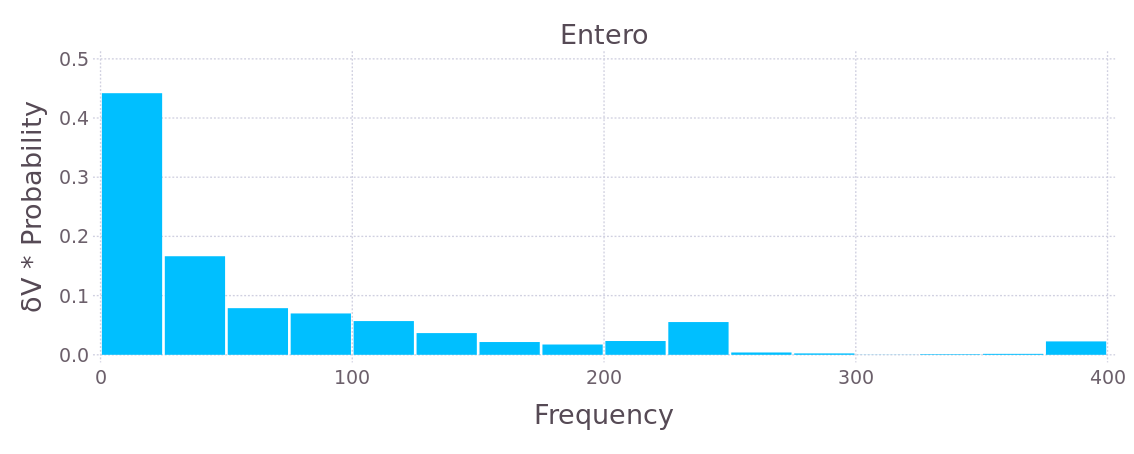

In [38]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_4xcp)
bins_evals = collect(0:25:400)

# Histograma ponderado
Whis_evals_4xcp, Wbins_evals_4xcp = WeightedHist(evals_4xcp, bins_evals, abs.(vgv_4xcp), true);
df_Whis_evals_4xcp = DataFrame(Probability = Whis_evals_4xcp, Frequency = Wbins_evals_4xcp);


pdf_Whis_evals_4xcp = plot(df_Whis_evals_4xcp, x="Frequency", y="Probability", Geom.bar,
    Guide.title("Entero"),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad

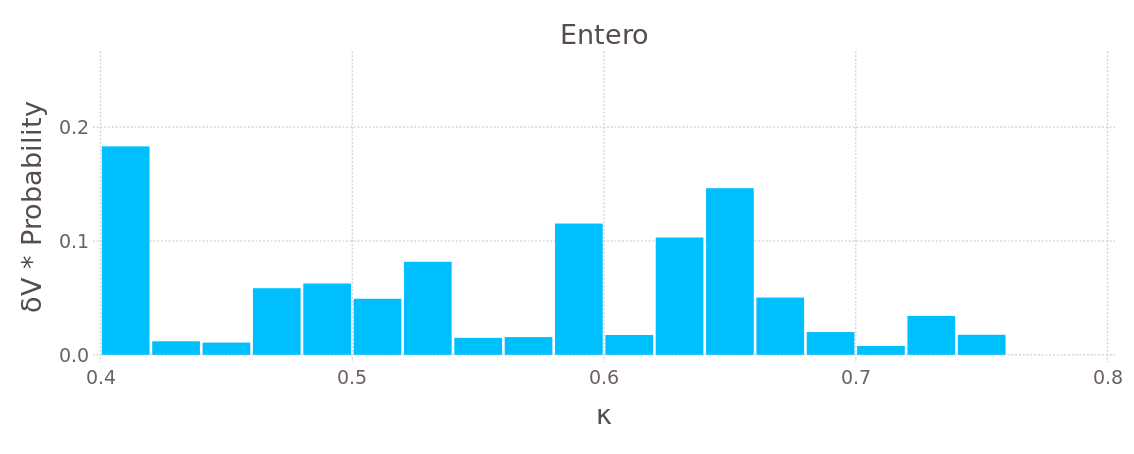

In [39]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_4xcp)
bins_κ = collect(0.4:.02:.8)

# Histograma ponderado
Whis_κ_4xcp, Wbins_κ_4xcp = WeightedHist(κ_modes_4xcp, bins_κ, abs.(vgv_4xcp), true);
df_Whis_κ_4xcp = DataFrame(Probability = Whis_κ_4xcp, κ = Wbins_κ_4xcp);

pdf_Whis_κ_4xcp = plot(df_Whis_κ_4xcp, x="κ", y="Probability", Geom.bar,
    Guide.title("Entero"),
    Coord.cartesian(ymax = 0.26),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

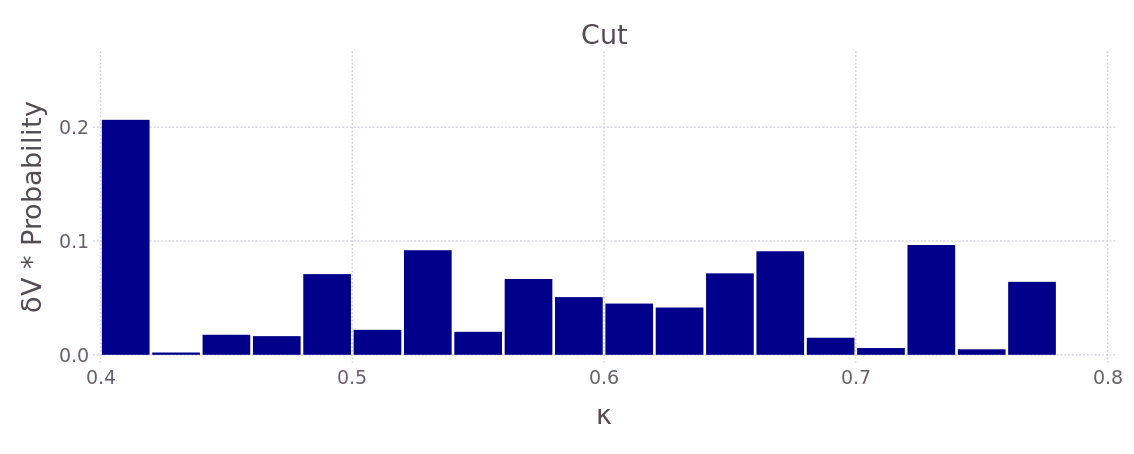

In [40]:
# Uso los bins del anterior
# Histograma ponderado
Whis_κ_cut_4xcp, Wbins_κ_cut_4xcp = WeightedHist(κ_modes_cut_4xcp, bins_κ, abs.(vgv_4xcp), true);
df_Whis_κ_cut_4xcp = DataFrame(Probability = Whis_κ_cut_4xcp, κ = Wbins_κ_cut_4xcp);

pdf_Whis_κ_cut_4xcp = plot(df_Whis_κ_cut_4xcp, x="κ", y="Probability", Geom.bar,
    Guide.title("Cut"),
    Coord.cartesian(ymax = 0.26),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad en pnumber

### Modos enteros

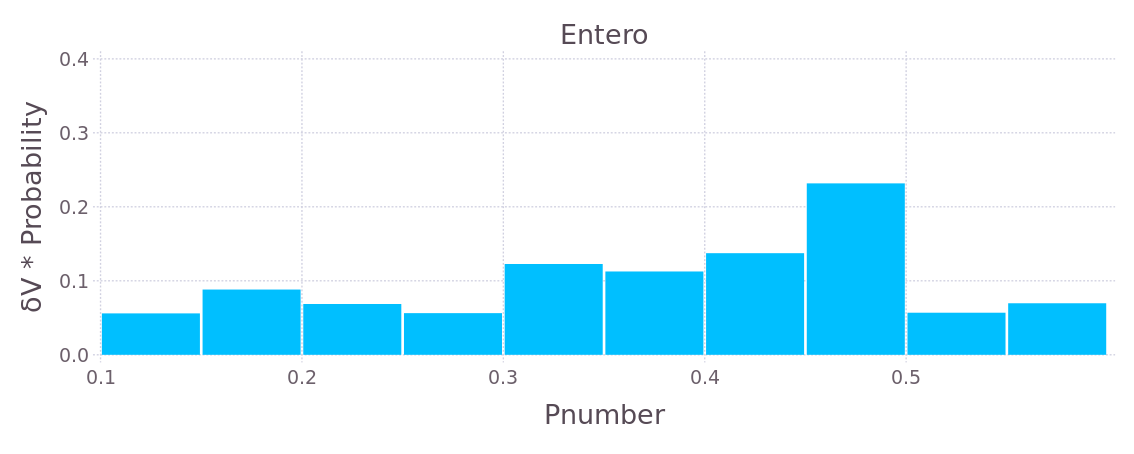

In [41]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_4xcp)
bins_col = collect(0.1:.05:.6)

# Histograma ponderado
Whis_col_4xcp, Wbins_col_4xcp = WeightedHist(col_modes_4xcp, bins_col, abs.(vgv_4xcp), true);
df_Whis_col_4xcp = DataFrame(Probability = Whis_col_4xcp, Pnumber = Wbins_col_4xcp);

pdf_Whis_col_4xcp = plot(df_Whis_col_4xcp, x="Pnumber", y="Probability", Geom.bar,
    Guide.title("Entero"),
    Coord.cartesian(xmin = 0.1, ymax = 0.4),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
    # Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Modos recortados

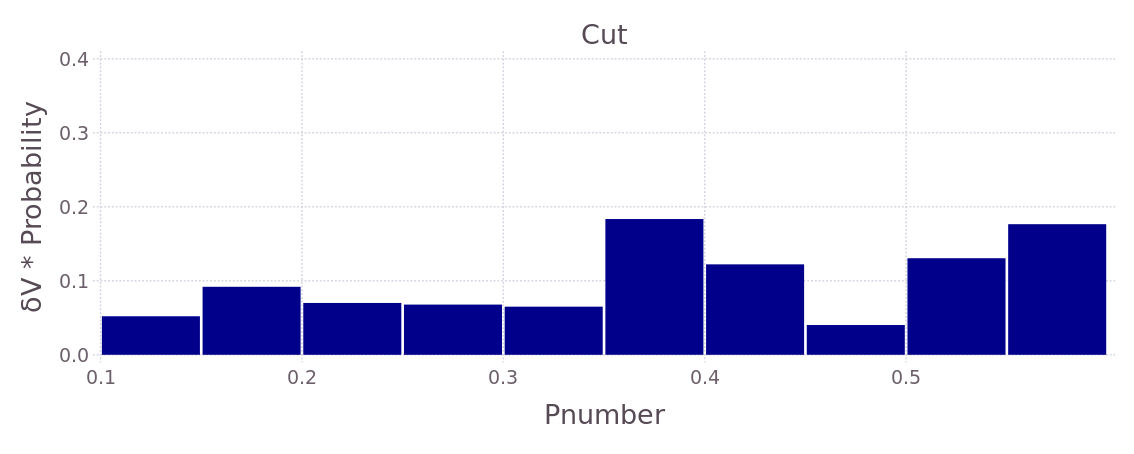

In [42]:
# Uso los bins de arriba
# Histograma ponderado
    Whis_col_cut_4xcp, Wbins_col_cut_4xcp = WeightedHist(col_modes_cut_4xcp, bins_col, abs.(vgv_4xcp), true);
df_Whis_col_cut_4xcp = DataFrame(Probability = Whis_col_cut_4xcp, Pnumber = Wbins_col_cut_4xcp);

pdf_Whis_col_cut_4xcp = plot(df_Whis_col_cut_4xcp, x="Pnumber", y="Probability", Geom.bar,
    Guide.title("Cut"),
    Coord.cartesian(xmin = 0.1, ymax = 0.4),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# AAs de la pared

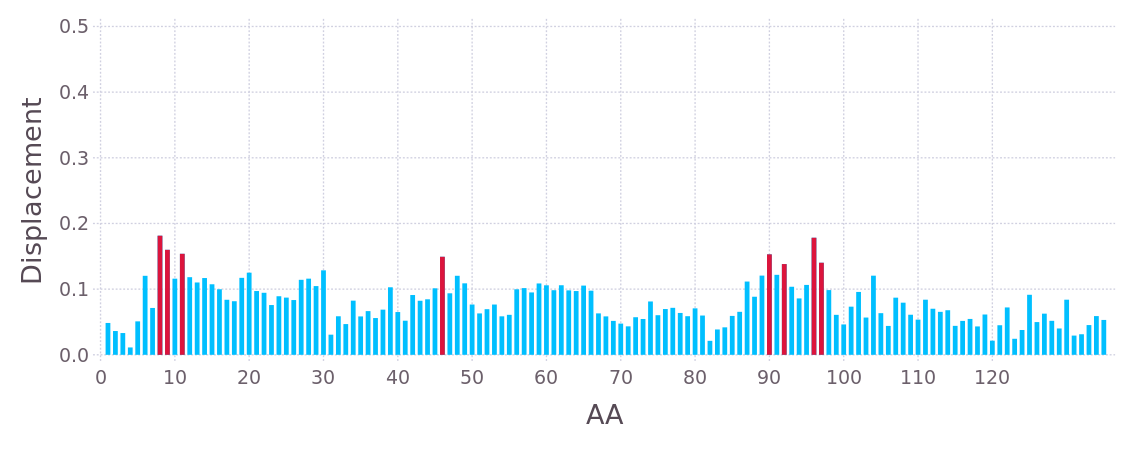

In [43]:
tmp = abs.(xyz_vgv_4xcp)
tmp_ = copy(tmp)
tmp_[tmp_ .< .13] .= 0.

layer_temp_1 = layer(DataFrame(Displacement = tmp), Geom.bar, y = "Displacement")
layer_temp_2 = layer(DataFrame(Displacement = tmp_), Geom.bar, y = "Displacement",
Theme(default_color=colorant"crimson", bar_spacing=2pt))


pdf_cart_gdte = plot(layer_temp_2, layer_temp_1,
    Guide.xlabel("AA"),
    Guide.ylabel("Displacement"), Coord.cartesian(ymax = 0.5),
    Guide.xticks(ticks=collect(0:10:120)),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
        key_label_font_size = 15pt))

## Volumen de la trayectoria

In [44]:
trj_vol = convert(Array{Float64, 1}, readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);
df_trj_vol = DataFrame(Volume = trj_vol, Time = collect(1:length(trj_vol)));

bin_vol = collect(400:50:1600)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Whis_vol_4xcp, Wbins_vol_4xcp = WeightedHist(trj_vol, bin_vol, wgh_vol, true);
df_Whis_vol_4xcp = DataFrame(Probability = Whis_vol_4xcp, Volume = Wbins_vol_4xcp);

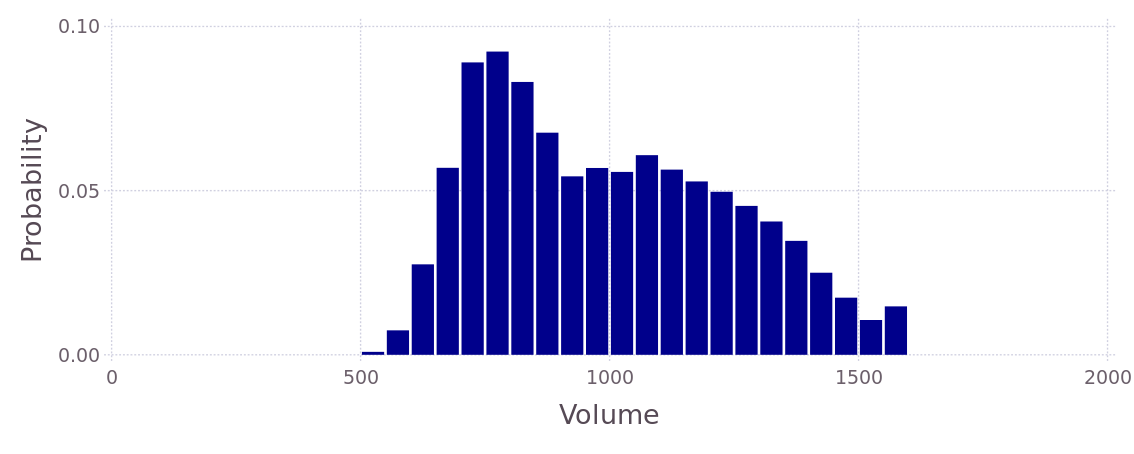

In [45]:
pdf_Whis_vol = plot(df_Whis_vol_4xcp, x = "Volume", y = "Probability", Geom.bar,
    #Guide.title("Cut"),
    #Coord.cartesian(xmin = 300, xmax = 1800, ymax = 0.002),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

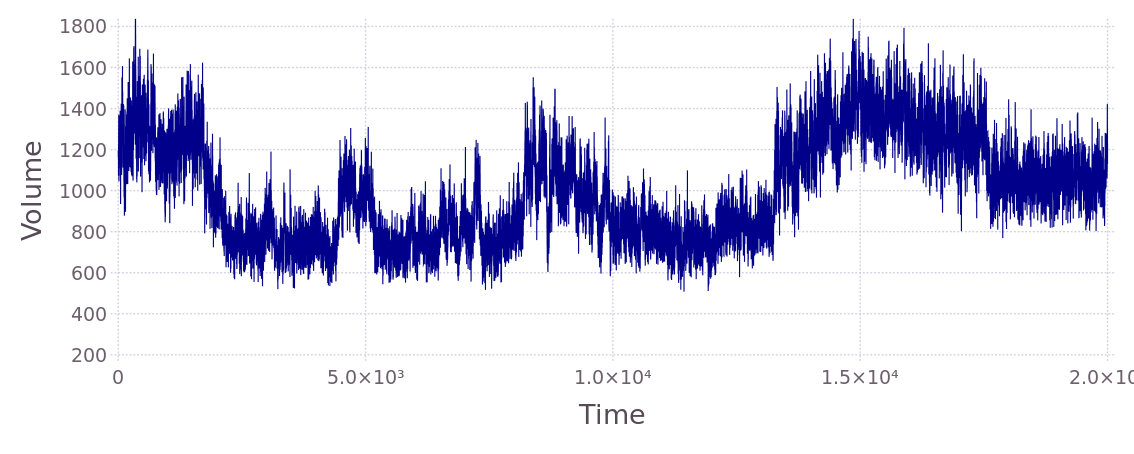

In [46]:
pdf_trj_vol = plot(df_trj_vol, x = "Time", y = "Volume", Geom.line,
    #Guide.title("Cut"),

    Coord.cartesian(xmin = 0, xmax = 20000, ymin = 200, ymax = 1800),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [47]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 999.511
 248.492

# Energía

In [48]:
points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

E_4xcp = Array{Float64,1}(points)
i = 0
for d = mini:maxi
    i+=1
    E_4xcp[i] = energia_gdte(evals_4xcp, vgv_4xcp, d * 5E-1)
end

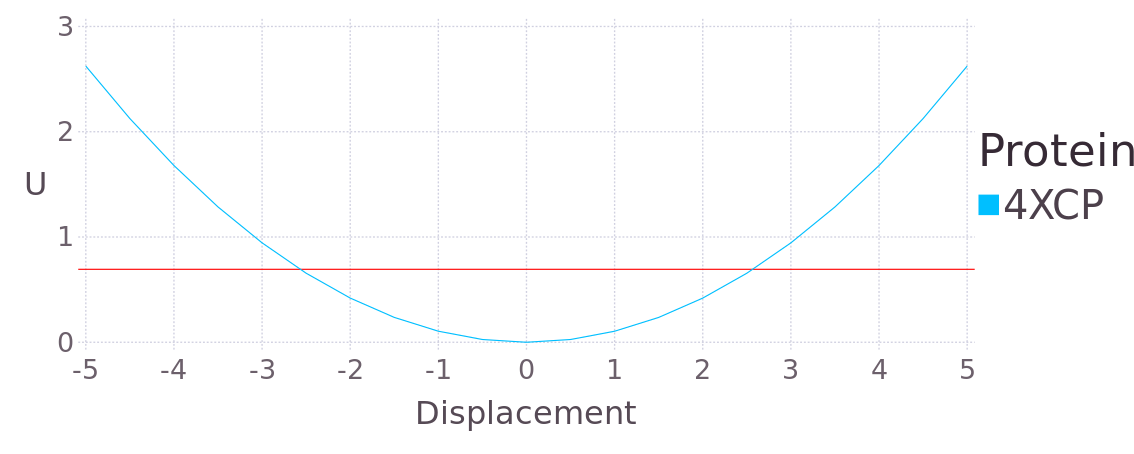

In [49]:
# Compilo en un dataframe.
df_E = DataFrame(U = E_4xcp,
    Displacement = repeat(collect(mini:1:maxi) * 5E-1, outer = [1]), 
    Protein = fill("4XCP", points))

pdf_E = plot(df_E, y = "U", x = "Displacement", color = "Protein", Geom.line,
    yintercept = [RT], Geom.hline(color = "red"),
    Guide.xticks(ticks = collect(mini:2:maxi) * 5e-1),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
        key_label_font_size = 30pt))

## Guardo datos

In [50]:
# Frecuencias
car_vgv_4xcp = modes_4xcp * vgv_4xcp
writetable(joinpath(rtdos, "freq_hist_4xcp"), df_Whis_evals_4xcp, separator = '\t')

# VGV cartesiano
car_vgv_4xcp = modes_4xcp * vgv_4xcp
writedlm(joinpath(rtdos, "car_vgv_4xcp"), car_vgv_4xcp)

# Histograma de volumen
writetable(joinpath(rtdos, "hist_vol_4xcp"), df_Whis_vol_4xcp, separator = '\t')

# Energías
writedlm(joinpath(rtdos, "energia_4xcp"), E_4xcp)